# CA5

### Imports

In [222]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, ConfusionMatrixDisplay

### Reading data

In [184]:
train_df = pd.DataFrame(pd.read_csv("train.csv"))
test_df = pd.DataFrame(pd.read_csv("test.csv"))

train_df[:10], train_df.size, test_df.size

(   Length (cm)  Width (cm)  Weight (g)  Pericarp Thickness (mm)  Seed Count  \
 0        17.37        5.42       94.30                     4.90      193.93   
 1        27.78        4.75      262.71                     6.56      186.29   
 2         6.17        3.51       66.72                     7.96      298.81   
 3         6.12        6.07       51.24                     4.57       39.36   
 4        28.58        4.84      166.51                     3.07      194.07   
 5        13.80        8.64      189.24                     4.32       72.27   
 6         9.15        8.40       74.69                     1.70        8.45   
 7        12.40       10.68      159.72                    10.28      239.54   
 8        18.90        7.66       57.72                     4.63       87.10   
 9        35.57        8.82      633.31                     6.92      244.27   
 
    Capsaicin Content  Vitamin C Content (mg)  Sugar Content  Moisture Content  \
 0               3.21               

In [185]:
train_df.dtypes

Length (cm)                                          float64
Width (cm)                                           float64
Weight (g)                                           float64
Pericarp Thickness (mm)                              float64
Seed Count                                           float64
Capsaicin Content                                    float64
Vitamin C Content (mg)                               float64
Sugar Content                                        float64
Moisture Content                                     float64
Firmness                                             float64
color                                                 object
Harvest Time                                          object
Average Daily Temperature During Growth (celcius)    float64
Average Temperature During Storage (celcius)          object
Scoville Heat Units (SHU)                            float64
dtype: object

In [186]:
train_df["Scoville Heat Units (SHU)"].nunique(), train_df["Scoville Heat Units (SHU)"].min(), train_df["Scoville Heat Units (SHU)"].max()

(460, 0.0, 527639.86)

### Data cleaning

In [187]:
train_df.isnull().sum(), test_df.isnull().sum()

(Length (cm)                                            1
 Width (cm)                                             1
 Weight (g)                                             1
 Pericarp Thickness (mm)                                2
 Seed Count                                             1
 Capsaicin Content                                      1
 Vitamin C Content (mg)                                 0
 Sugar Content                                          1
 Moisture Content                                       0
 Firmness                                               1
 color                                                  1
 Harvest Time                                           0
 Average Daily Temperature During Growth (celcius)      0
 Average Temperature During Storage (celcius)         648
 Scoville Heat Units (SHU)                              0
 dtype: int64,
 Length (cm)                                            2
 Width (cm)                                             0

### Data preprocessing and visualisation

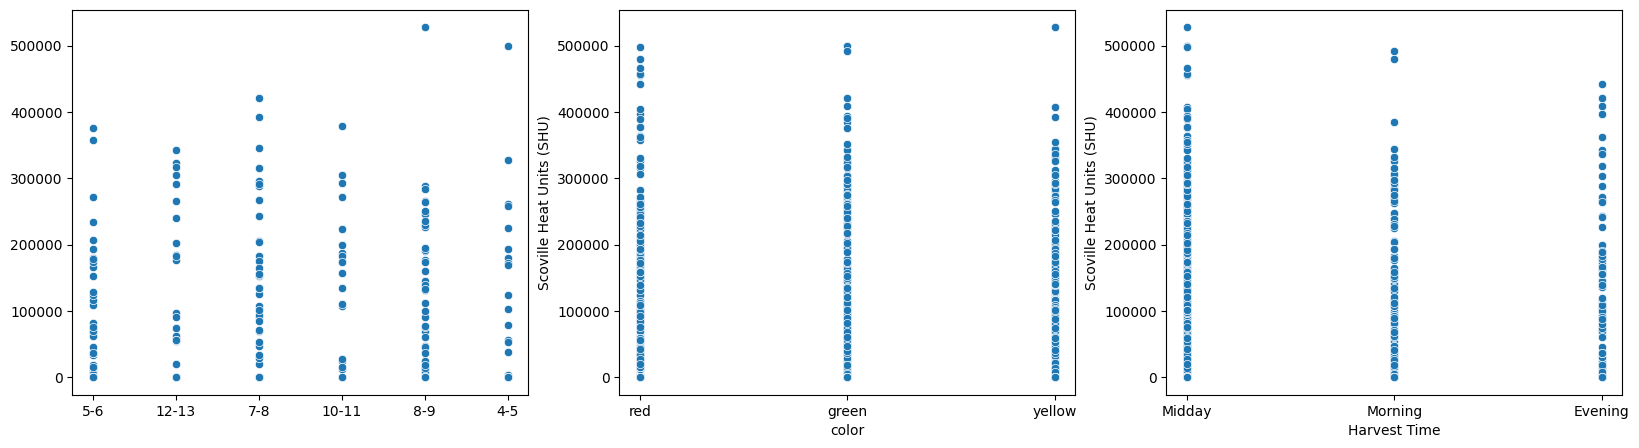

In [188]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
sns.scatterplot(x=train_df["Average Temperature During Storage (celcius)"].values, y=train_df["Scoville Heat Units (SHU)"].values, ax=ax[0])
sns.scatterplot(x=train_df["color"], y=train_df["Scoville Heat Units (SHU)"], ax=ax[1])
sns.scatterplot(x=train_df["Harvest Time"], y=train_df["Scoville Heat Units (SHU)"], ax=ax[2])
plt.show()

In [189]:
"""
Since the categorical features show so little correlation with the target variable, I decide to remove the columns "Average Temperature During
Storage (celsius)" and "Harvest Time". Logically, it seems unlikely that storage temperature and harvest time should have an impact on spice.
Moreover, the plots show no direct correlation between these variables and the target variable, and the storage temperature column has very many NaN-values.
Alternatively, I could have altered the values to numerical, e.g. by setting the value of temperature to the mean (5.5 for 5-6) and giving the 
time-of-day variable index labels - if they had proven themselves useful. However, I decide to keep the colour-column for now, as it could
be somehow descriptive in combination with other physical features. I'll then assign index labels (0, 1, 2) to the colours.
"""

columns_to_drop = ["Average Temperature During Storage (celcius)", "Harvest Time"]
train_df = train_df.drop(columns_to_drop, axis=1)
test_df = test_df.drop(columns_to_drop, axis=1)

colour_mapping = {"red": 0, "green": 1, "yellow": 2}
train_df["color"] = train_df["color"].replace(colour_mapping)
test_df["color"] = test_df["color"].replace(colour_mapping)
print(train_df.dtypes)

# Delete rows with NaN-values, since they are so few
train_df = train_df.dropna()

# Mapping target value into 

train_df["Scoville Heat Units (SHU)"].max()

Length (cm)                                          float64
Width (cm)                                           float64
Weight (g)                                           float64
Pericarp Thickness (mm)                              float64
Seed Count                                           float64
Capsaicin Content                                    float64
Vitamin C Content (mg)                               float64
Sugar Content                                        float64
Moisture Content                                     float64
Firmness                                             float64
color                                                float64
Average Daily Temperature During Growth (celcius)    float64
Scoville Heat Units (SHU)                            float64
dtype: object


C:\Users\kroel\AppData\Local\Temp\ipykernel_17956\3770391725.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_df["color"] = train_df["color"].replace(colour_mapping)
C:\Users\kroel\AppData\Local\Temp\ipykernel_17956\3770391725.py:16: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_df["color"] = test_df["color"].replace(colour_mapping)


527639.86

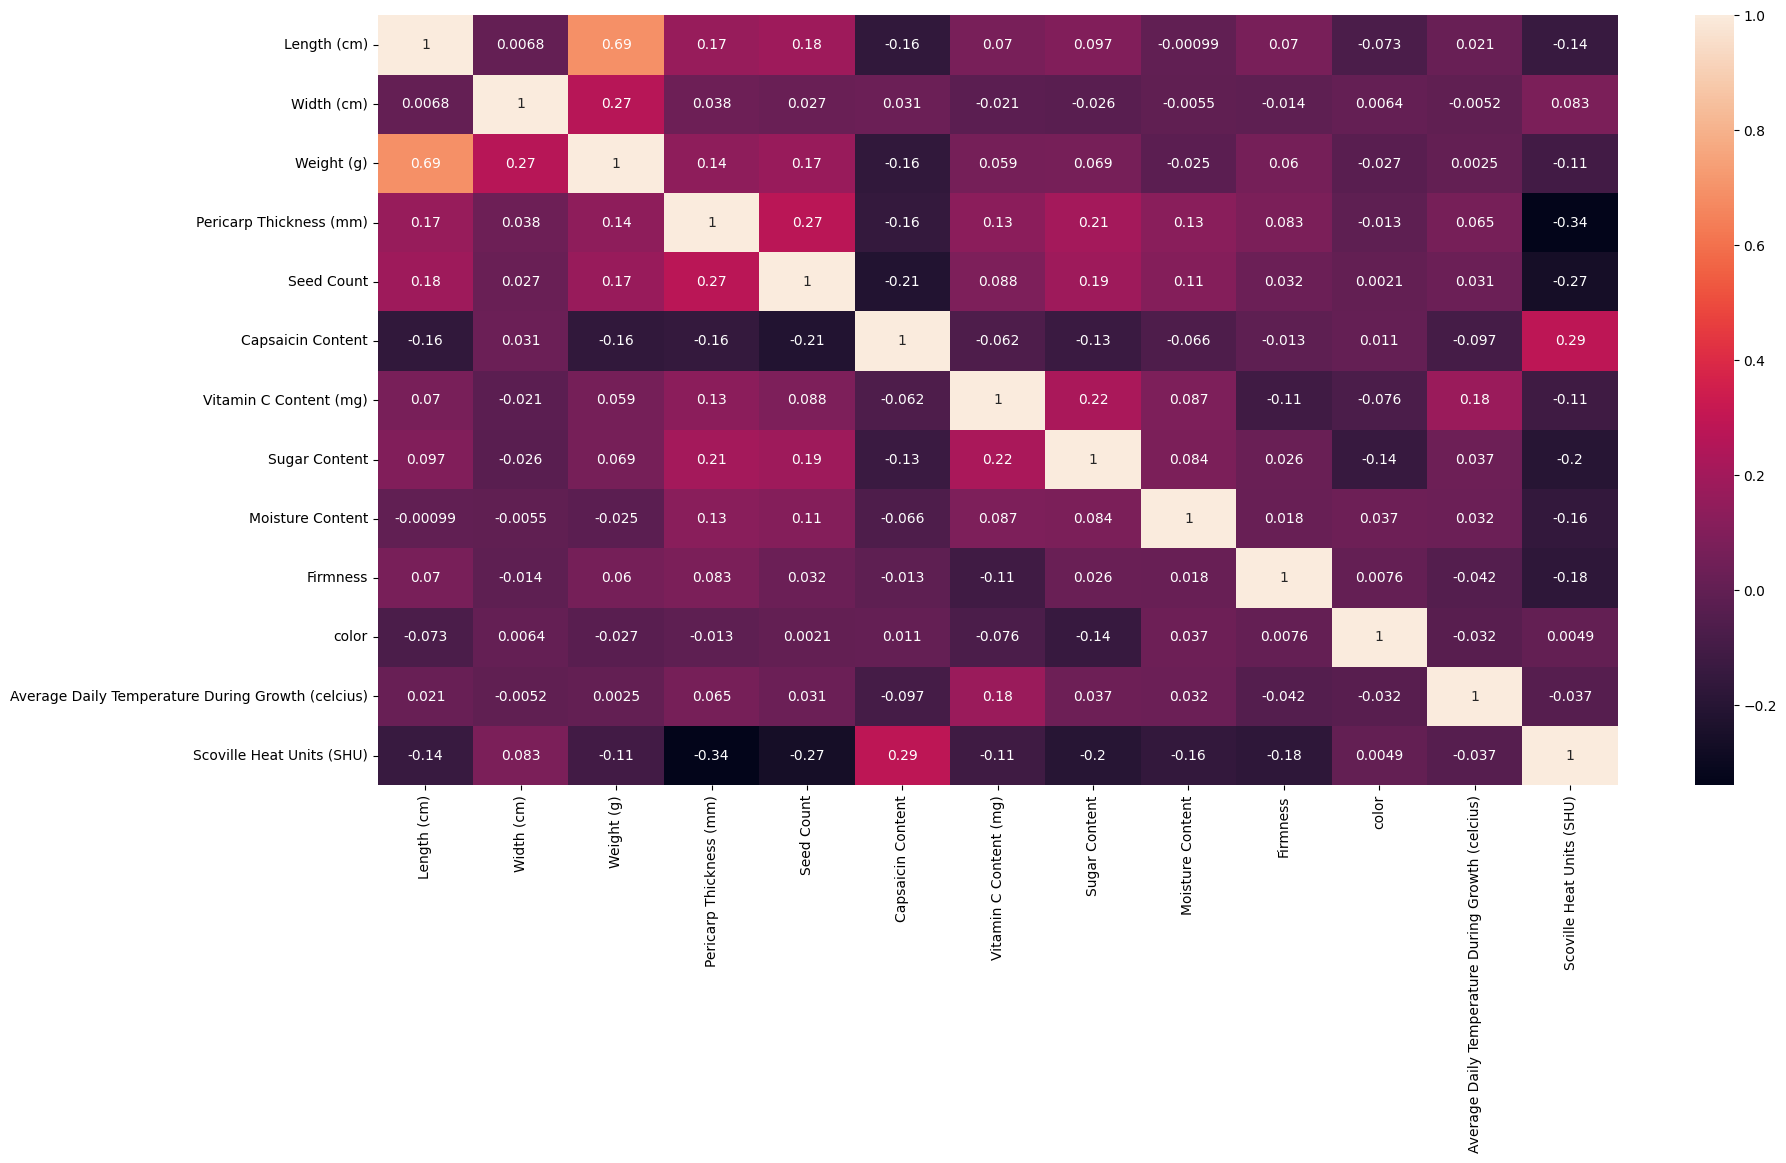

In [190]:
# Linear correlation map
plt.figure(figsize=(20, 10))
sns.heatmap(train_df.corr(), annot=True)
plt.show()

The linear correlation plot shows no significant linear correlation between any features of interest. I move on by plotting scatterplots of the target column together with the other columns to check for other kinds of correlation.

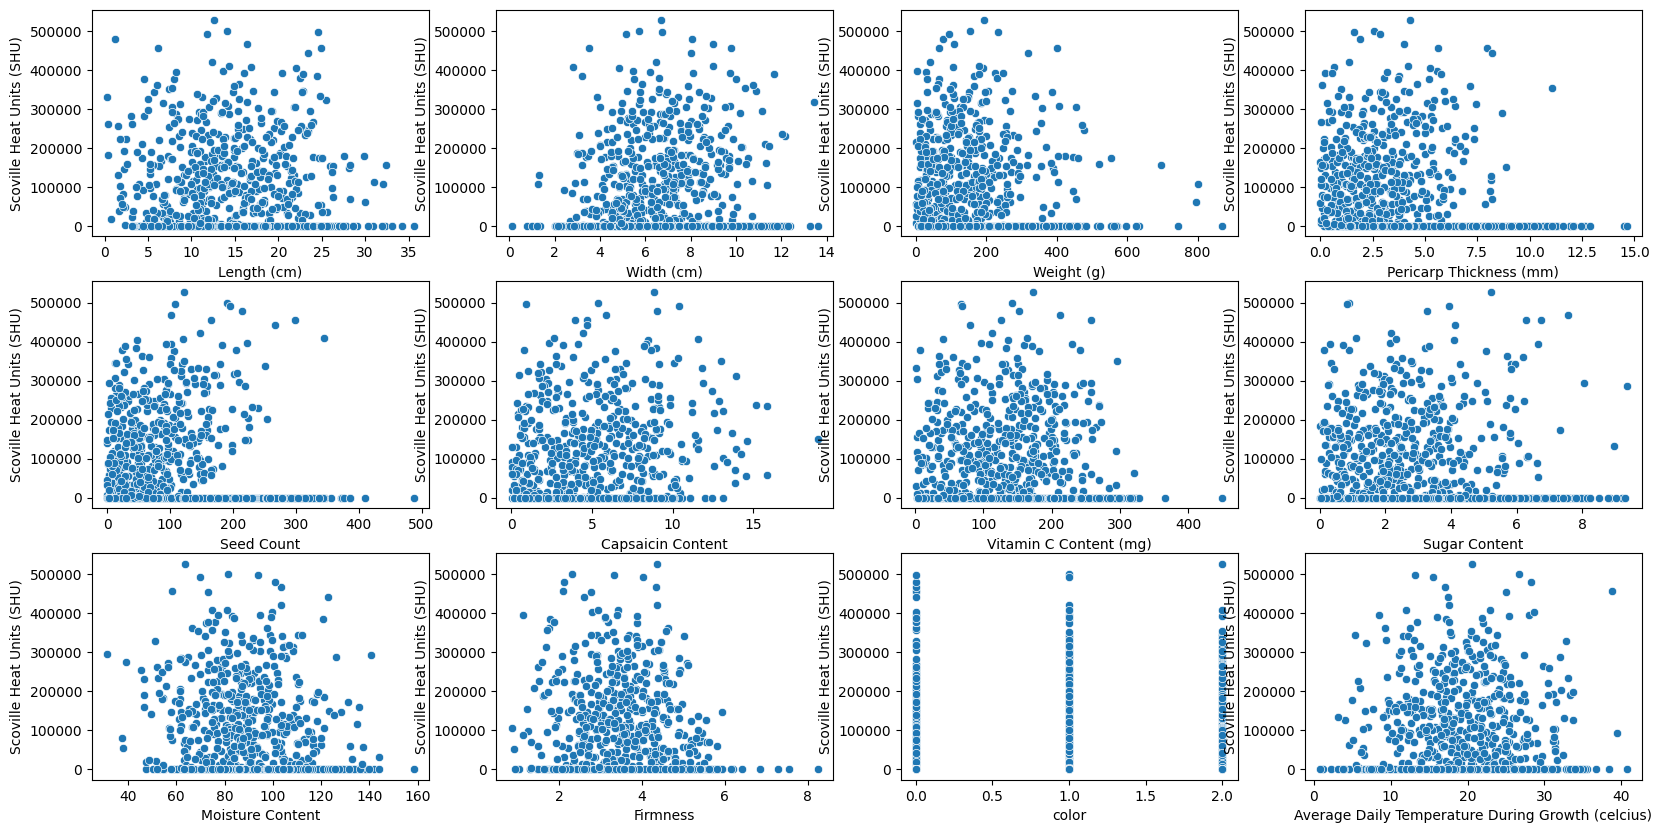

Index(['Length (cm)', 'Width (cm)', 'Weight (g)', 'Pericarp Thickness (mm)',
       'Seed Count', 'Capsaicin Content', 'Vitamin C Content (mg)',
       'Sugar Content', 'Moisture Content', 'Firmness', 'color',
       'Average Daily Temperature During Growth (celcius)',
       'Scoville Heat Units (SHU)'],
      dtype='object')

In [191]:
fig, ax = plt.subplots(3, 4, figsize=(20, 10))
plot_row = 0
plot_column = 0
for feature in train_df.columns.drop("Scoville Heat Units (SHU)"):
    if feature == "Scoville Heat Units (SHU)":
        pass
    sns.scatterplot(x=train_df[feature], y=train_df["Scoville Heat Units (SHU)"], ax=ax[plot_row, plot_column])
    if plot_column == 3:
        plot_column = 0
        plot_row += 1
    else:
        plot_column += 1
plt.show()

train_df.columns

### Comments on the visualisation ###
There seem to be no features here that are immediately revealing as to where the peppers spice is located on the Scoville scale. I'll leave it up to LDA (my chosen feature selector this time) to see if there are some suitable selections.

### Train / dev split ###

In [209]:
y = train_df["Scoville Heat Units (SHU)"].values
X = train_df.drop("Scoville Heat Units (SHU)", axis=1).values

X_train, X_dev, y_train, y_dev = train_test_split(X, y, train_size=0.7, random_state=42)

y_train_b = [0 if x == 0 else 1 for x in y_train]
y_dev_b = [0 if x == 0 else 1 for x in y_dev]

print(y_train_b, y_dev_b)


[0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 

### Modelling

In [219]:
# Setting up pipelines with my chosen classifiers

# Regression analysis
pls = Pipeline([
    ('pls', PLSRegression())
])

# Ensemble classifier
xgb = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBRegressor(objective='reg:squarederror', n_jobs=-1))
])

lr = Pipeline([
    ('lr', LinearRegression(n_jobs=-1))
])

rf = Pipeline([
    ('scaler', StandardScaler()),
    ('lda', LinearDiscriminantAnalysis(n_components=.9)),
    ('rf', RandomForestClassifier(random_state=42, n_jobs=-1)), 
])

print(f"PLS parameters: {pls.get_params()}")
print(f"XGBoost parameters: {xgb.get_params()}")
print(f"RandomForest parameters: {rf.get_params()}")

PLS parameters: {'memory': None, 'steps': [('pls', PLSRegression())], 'verbose': False, 'pls': PLSRegression(), 'pls__copy': True, 'pls__max_iter': 500, 'pls__n_components': 2, 'pls__scale': True, 'pls__tol': 1e-06}
XGBoost parameters: {'memory': None, 'steps': [('scaler', StandardScaler()), ('xgb', XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=-1, num_parallel_tree=None,
             

In [213]:
estimators = np.linspace(1, 1300, 1300, dtype=int)
depths = np.linspace(1, 15, 15, dtype=int)
learning_rates = np.linspace(0, 1, 10)

print(estimators, depths, learning_rates)

pls_grid = {"pls__n_components": components}

xgb_grid = {"xgb__n_estimators": estimators, "xgb__max_depth": depths, "xgb__eta": learning_rates}

rf_grid = {"rf__n_estimators": estimators, "rf__max_depth": depths}

[   1    2    3 ... 1298 1299 1300] [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] [0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889 1.        ]


In [214]:
pls_search = GridSearchCV(estimator=pls,
                          param_grid=pls_grid,
                          scoring='neg_mean_absolute_error',
                          cv=10,
                          n_jobs=-1,
                          verbose=2)

xgb_search = RandomizedSearchCV(estimator=xgb,
                                param_distributions=xgb_grid,
                                scoring='neg_mean_absolute_error',
                                n_iter=100,
                                cv=10,
                                n_jobs=-1,
                                verbose=2)

lr_search = GridSearchCV(estimator=lr,
                        param_grid={},
                        scoring='neg_mean_absolute_error',
                        cv=10,
                        n_jobs=-1,
                        verbose=2)

rf_search = RandomizedSearchCV(estimator=rf,
                                param_distributions=rf_grid,
                                scoring='accuracy',
                                cv=10,
                                n_jobs=-1)

In [196]:
searches = {"PLS": pls_search, "XGBoost": xgb_search, "Linear Regression": lr_search}
for search in searches:
    searches[search].fit(X_train, y_train)
    print(f'Best parameters for {search}: {searches[search].best_params_}')
    print(f'Best score for {search}: {abs(searches[search].best_score_)}')


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best parameters for PLS: {'pls__n_components': 2}
Best score for PLS: 68191.02565355867
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Best parameters for XGBoost: {'xgb__n_estimators': 18, 'xgb__max_depth': 8, 'xgb__eta': 0.2222222222222222}
Best score for XGBoost: 67323.29997768448
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Best parameters for Linear Regression: {}
Best score for Linear Regression: 68453.15840894058


In [220]:
rf_search.fit(X_train, y_train_b)
print(f'Best parameters for Random Forest: {rf_search.best_params_}')
print(f'Best score for Random Forest: {rf_search.best_score_}')

Best parameters for Random Forest: {'rf__n_estimators': 241, 'rf__max_depth': 10}
Best score for Random Forest: 0.8629813664596273


### Final evaluation

In [198]:
best_model = xgb_search.best_estimator_
y_pred_xgb = best_model.predict(X_dev)
mean_absolute_error(y_dev, y_pred_xgb)

66032.10667992588

### Kaggle submission

In [199]:
best_model.fit(X, y)
X_test = test_df.values
y_pred = best_model.predict(X_test)

submission_df = pd.DataFrame(y_pred, columns=['Scoville Heat Units (SHU)'])
submission_df.to_csv("XGBRegressor.csv", index_label="index")